# Adapting BERT classifier for Entailment 
## Retraining on RQE data using the same format as in Fine-Tuning with BERT

NOTE: Adapted from Dr.Zadrozny's notebook, with additions for:
  - Additional transformers (ALBERT and XLM)
  - Data augmentation (Quora and CoLA)
  - Optional masking

Source: https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb

This is an almost identical private version. I removed some comments and added a section of using BERT for entailment by retraining on pairs of sentence. 

## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time. A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [0]:
from datetime import datetime 
"""
print(f'Beginning Training!')
print(f'num_train_steps= ', num_train_steps)
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)
"""
current_time = datetime.now()

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Time took ", datetime.now() - current_time)

Found GPU at: /device:GPU:0
Time took  0:00:01.218644


Next, let's install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained language models (and future models to come - BERT will not be state of the art forever), the library also includes pre-built modifications of BERT suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification, but the library also includes BERT modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

**Note**: as of July 2019, the pytorch library called "pytorch-pretrained-bert pytorch-nlp" has been updated and renamed as "pytorch-transformers." Though the old name still works, there is a short summary [here](https://github.com/huggingface/pytorch-transformers#Migrating-from-pytorch-pretrained-bert-to-pytorch-transformers) about migrating to the new library. (This mostly involves a few name changes.)

In [0]:
!pip install pytorch-transformers

In [0]:
!pip install transformers

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_transformers import BertTokenizer, BertForSequenceClassification, RobertaModel, RobertaTokenizer
from transformers import AlbertTokenizer, AlbertForSequenceClassification, XLMTokenizer, XLMForSequenceClassification
from pytorch_transformers import RobertaForSequenceClassification, RobertaConfig, AdamW, optimization
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

print("Time took up to here ", datetime.now() - current_time)

Using TensorFlow backend.


Time took up to here  0:00:10.896994


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print("CUDA: ", torch.cuda.get_device_name(0))

CUDA:  Tesla P100-PCIE-16GB


In [0]:
print("The setup time: ", datetime.now() - current_time)

The setup time:  0:00:10.914201


## Load Dataset


**Mount drive** -- my preferred solution 

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
'My Drive'


In [0]:
### ALTERNATIVE 
# Upload the train file from your local drive
"""
from google.colab import files
uploaded = files.upload()
"""

'\nfrom google.colab import files\nuploaded = files.upload()\n'

In [0]:
""" ANOTHER ALTERNATIVE 
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
"""
drive.mount('/content/drive',force_remount=True) #occasionally needed

Mounted at /content/drive


In [0]:
%%bash

ls /content/drive/My\ Drive/ 

Anthem NLP Ideas.gdoc
Applied NLP Final Report .gdoc
Applied NLP Homework-Paper Comparison.gslides
Boli
Clinical+Tech Venture
Colab Notebooks
Copy of BME MML: Python Quiz Review.gdoc
craigslist-carstrucks-data
Databased.gslides
Data Dialogues Week 1 Questions.gdoc
DJ Vigs
DS Interview Prep.gdoc
Duke Surgery Capstone Whitepaper-Fall.gdoc
Final Project Outline-MML.gdoc
LCA.ipynb
Lofts At Lakeview.pdf
MML Project Doc.gdoc
Resume-Vignesh Kumaresan.docx
Resume-Vignesh Kumaresan.pdf
Rotational CoordConv .gslides
Stats.zip
(Working) Copy of FAUJ Lighting Cue Template.gsheet


In [0]:
dfe = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/Final Notebooks/Copy of OneL-RQE_Train_8588_AMIA2016.tsv", delimiter='\t', \
                  header=None, names=['pair_num', 'label', 'label_notes', 'pairs'])

print(dfe.shape)

dfe.sample(10)

### TODO: randomize dfe

(8588, 4)


,pair_num,label,label_notes,pairs
8021,pid8022typeoriginalQ-shortQ,1,NaN,chq Do we need to do a work-up on this patient...
485,pid486typeoriginalQ-shortQ,1,NaN,chq This child had some flea bites. Question i...
6476,pid6477typeoriginalQ-shortQ,1,NaN,chq This question relates to a phone message w...
7769,pid7770typeoriginalQ-shortQ,1,NaN,chq What do you watch for with a gastroschisis...
8080,pid8081typeoriginalQ-shortRandQ,0,NaN,chq Iron ingestion - borderline. Needed to kno...
3742,pid3743typeoriginalQ-shortRandQ,0,NaN,chq Does pregnancy exacerbate chronic fatigue ...
2261,pid2262typeoriginalQ-shortRandQ,0,NaN,chq Of what value is it to know the A-a gradie...
1033,pid1034typeoriginalQ-shortQ,1,NaN,chq Does it matter if you do a rectal exam bef...
2646,pid2647typeoriginalQ-shortQ,1,NaN,chq What is Still's disease? echq faq What is ...
3190,pid3191typeoriginalQ-shortQ,1,NaN,chq Can hemochromatosis cause skin hyperpigmen...


Data augmentation (optional)

In [0]:
# cola
#cola = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
#cola.shape

In [0]:
# quora
quora = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/questions.csv", delimiter=',', header=0)
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
#preprocess
quora['question_text'] = 'q1 ' + quora['question1'] + ' eq1 ' + 'q2 ' + quora['question2'] + ' eq2'
quora['question_text'] = quora['question_text'].astype(str)
quora['question_text'].iloc[0]

'q1 What is the step by step guide to invest in share market in india? eq1 q2 What is the step by step guide to invest in share market? eq2'

In [0]:
quora.shape

(404351, 7)

In [0]:
quora

,id,qid1,qid2,question1,question2,is_duplicate,question_text
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,q1 What is the step by step guide to invest in...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,q1 What is the story of Kohinoor (Koh-i-Noor) ...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,q1 How can I increase the speed of my internet...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,q1 Why am I mentally very lonely? How can I so...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"q1 Which one dissolve in water quikly sugar, s..."
...,...,...,...,...,...,...,...
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,q1 How many keywords are there in the Racket p...
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1,q1 Do you believe there is life after death? e...
404348,404348,789796,789797,What is one coin?,What's this coin?,0,q1 What is one coin? eq1 q2 What's this coin? eq2
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,q1 What is the approx annual cost of living wh...


In [0]:
# subset of quora, for processing purposes
quora = quora[:100000]
quora.shape

(100000, 7)

## Preparing the data 

In [0]:
# Create sentence and label lists (we mark the new version by e)
esentences = dfe.pairs.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
esentences = ["[CLS] " + p + " [SEP]" for p in dfe.pairs]

elabels = dfe.label.values

# # cola
# sentences_cola = cola.sentence.values
# sentences_cola = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_cola]
# labels_cola = cola.label.values

# # append cola onto rqe_train
# esentences = np.append(esentences,sentences_cola)
# elabels = np.append(elabels, labels_cola)

# quora
sentences_quora = quora.question_text
sentences_quora = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_quora]
labels_quora = quora.is_duplicate.values

# # append quora onto rqe_train
#esentences = np.append(esentences,sentences_quora)
#elabels = np.append(elabels, labels_quora)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  
#tokenizer = AlbertTokenizer.from_pretrained('albert-xlarge-v2', do_lower_case=True)
#tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli', do_lower_case=True)
#tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-100-1280', do_lower_case=True)



tokenized_etexts = [tokenizer.tokenize(sent) for sent in esentences]
print ("Tokenize a sentence:")
print (tokenized_etexts[3])

print(len(esentences), len(elabels))
print("Time took up to here ", datetime.now() - current_time)

Tokenize a sentence:
['[CLS]', 'ch', '##q', 'let', "'", 's', 'give', 'these', 'im', '##mun', '##izations', '.', 'that', "'", 's', 'right', 'isn', "'", 't', 'it', '?', 'ec', '##h', '##q', 'fa', '##q', 'let', "'", 's', 'give', 'these', 'im', '##mun', '##izations', '.', 'that', "'", 's', 'right', 'isn', "'", 't', 'it', '?', 'e', '##fa', '##q', '[SEP]']
8588 8588
Time took up to here  0:00:21.583853


In [0]:
# Create test set, shuffled
from sklearn.model_selection import train_test_split

esentences, test_pairs, tokenized_etexts, test_tokenized_etexts, elabels, test_labels = train_test_split(esentences, tokenized_etexts, elabels, test_size=0.2, random_state=24)
#test_pairs=esentences[:1500]
#test_labels= elabels[:1500]
#test_tokenized_etexts = tokenized_etexts[:1500]

#esentences= esentences[1500:]
#elabels=elabels[1500:]
#tokenized_etexts = tokenized_etexts[1500:]


print(len(esentences), len(elabels),len(tokenized_etexts))

6870 6870 6870


Masking (optional)

In [0]:
# import random

# esentences_masked = []

# # tags to skip
# skipped_chars = ['chq', 'echq', 'faq', 'efaq']
# for sent in esentences:
#   #print(sent)
#   #print(type(sent))
#   #print(len(sent.split(' ')))
#   sent_length = len(sent.split(' '))
#   indices = [i for i in range(1, sent_length-1)]
#   mask_indices = random.sample(indices, int(0.15*sent_length))
#   sent_split = sent.split(' ')
#   #print(mask_indices)
#   for c, n in enumerate(sent_split):
#     if c in mask_indices:
#       #print(c)
#       if sent_split[c] not in skipped_chars:
#         sent_split[c] = "[MASK]"
#   sent = ' '.join(sent_split)
#   esentences_masked.append(sent)

# tokenized_etexts = [tokenizer.tokenize(sent) for sent in esentences_masked]

In [0]:
print(len(test_pairs), len(test_labels),len(test_tokenized_etexts))

1718 1718 1718


In [0]:
#esentences_masked[0]

In [0]:
esentences[0]

'[CLS] chq Is this chest pain due to coronary disease? Electrocardiogram just shows an old myocardial infarction. echq faq In this patient with transient ischemic attacks and no murmur, should I do an echocardiogram anyway? efaq [SEP]'

In [0]:
elabels[0]

0

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is ??? ,  
# In the original paper, the authors used a length of 512.
MAX_LEN = 128 # this will cut 60 sentences assuming this is length in characters
          #512 is too much for Tesla 4 on colab


# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
einput_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_etexts]

# Pad our input tokens
einput_ids = pad_sequences(einput_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


# Create attention masks
attention_emasks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in einput_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_emasks.append(seq_mask)




# Making sure we have the right shapes
print(1,einput_ids.shape)
print(2,elabels.shape)

print(einput_ids.shape)
print(elabels.shape)



# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(einput_ids, elabels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_emasks, einput_ids,
                                             random_state=2018, test_size=0.1)


print("Time took up to here ", datetime.now() - current_time)

1 (6870, 128)
2 (6870,)
(6870, 128)
(6870,)
Time took up to here  0:00:22.454732


### Comments on the Inputs 
(from the origininal)

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

## Train Model

see the original

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:00:22.493271


In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
#model = RobertaForSequenceClassification.from_pretrained("roberta-large-mnli", num_labels=2)
#model = AlbertForSequenceClassification.from_pretrained('albert-xlarge-v2', num_labels=2)
#model = XLMForSequenceClassification.from_pretrained('xlm-mlm-100-1280', num_labels=2)

model.cuda()

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:00:28.505626


Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=3e-5,
#                      warmup=.1)
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    #loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].data.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


print("Time took up to here ", datetime.now() - current_time)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.18054161244792113


Epoch:  50%|█████     | 1/2 [01:22<01:22, 82.22s/it]

Validation Accuracy: 0.9815340909090909
Train loss: 0.07288791812457067


Epoch: 100%|██████████| 2/2 [02:44<00:00, 82.23s/it]

Validation Accuracy: 0.9900568181818182
Time took up to here  0:03:13.053195


Total time from the start and 1 epoch training: 16min
one epoch 3-4 min. (w. GPU)

## Training Evaluation

Let's take a look at our training loss over all batches:

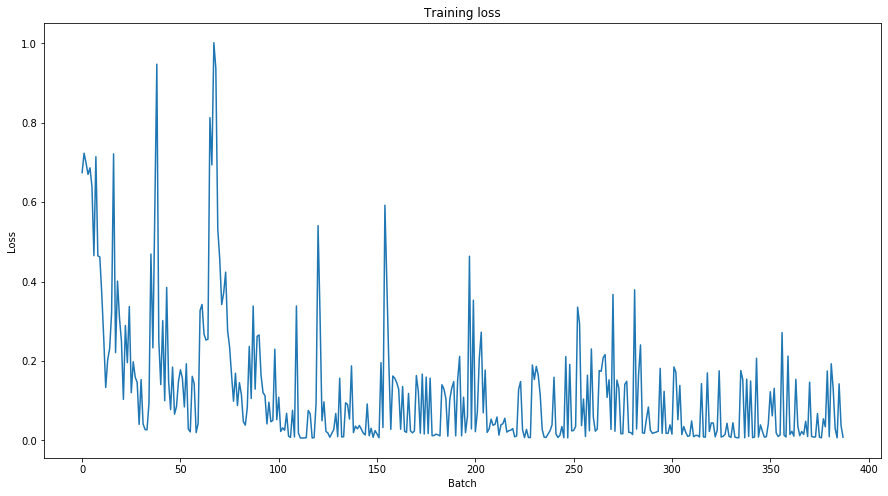

Time took up to here  0:03:13.306968


In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

print("Time took up to here ", datetime.now() - current_time)

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

We previously defined: 

test_pairs=esentences[:1500]

test_labels= elabels[:1500]

test_tokenized_etexts = tokenized_etexts[:1500]

In [0]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = test_pairs
labels =  test_labels

tokenized_texts = test_tokenized_etexts


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:03:13.532244


In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits[0].data.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print("Time took up to here ", datetime.now() - current_time)

Time took up to here  0:03:20.592791


In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)


print("Time took up to here ", datetime.now() - current_time)

print(matthews_set)

Time took up to here  0:03:20.633710
[1.0, 1.0, 0.936441710371274, 0.9393364366277243, 1.0, 1.0, 1.0, 0.8614718614718615, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7984472665856134, 0.8745098039215686, 0.938872452190116, 1.0, 0.9379228369755696, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.936441710371274, 1.0, 1.0, 1.0, 0.936441710371274, 1.0, 0.9393364366277243, 1.0, 1.0, 1.0, 1.0, 0.8805899139163632, 1.0, 0.9278305692406299, 1.0, 0.936441710371274, 0.9379228369755696, 0.9315409787235999, 1.0, 0.936441710371274, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


print(matthews_corrcoef(flat_true_labels, flat_predictions))

print("TOTAL time ", datetime.now() - current_time)

0.9754150289726646
TOTAL time  0:03:20.645997


### Looking at the results

In [0]:
count=0
for i in range(len(flat_true_labels)):
  if np.abs(flat_predictions[i]-flat_true_labels[i])==1:
    #print(i, flat_predictions[i]-flat_true_labels[i])
    print(i, sentences[i])
    count+=1
print('incorrect', count)
accuracy = (len(flat_true_labels)-count)/len(flat_true_labels)
print('accuracy: ', accuracy)

71 [CLS] chq This family was heating their house with an open stove because they didn't think the furnace was keeping the house warm enough. The 6-year-old boy came in with muscle aches, arthralgias, headaches, and cold symptoms. One question was whether the stove could cause carbon monoxide poisoning. echq faq What is the normal carboxyhemoglobin in the blood? efaq [SEP]
120 [CLS] chq We get these young girls with periods every two weeks for a year. "When do you get concerned? When do you regulate them? When do you refer?" echq faq What is the approach to irregular bleeding in adolescents? efaq [SEP]
237 [CLS] chq I (investigator) noted an open book on the physician's desk and asked if there was an associated question recently. "I was looking up to see what the standards are for hypertension in the newborn and the workup of hypertension if it continued." echq faq Is there a handy reference to ophthalmologic drugs? efaq [SEP]
240 [CLS] chq 13-year-old, former shaken baby with resultant

## Test on validation set

In [0]:
# upload test file
dfe_val = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/rqe_test_pairs.tsv", delimiter='\t', \
                  header=0, names=['pair_num', 'type', 'label', 'chq', 'faq', 'pairs'])

print(dfe_val.shape)
# drop non-relevant variables
dfe_val.drop(columns=['type', 'chq', 'faq'], inplace=True)
dfe_val.sample(10)

(302, 6)


,pair_num,label,pairs
82,83,1,chq growth on the neck. can drug remove growth...
122,123,1,chq I have had renal organ transplant surgery ...
64,65,0,chq recovery after stroke?. What is the patter...
128,129,1,chq ClinicalTrials.gov - Question - general in...
40,41,0,"chq Kidney Stone. Hello Dr.,In a case of patie..."
20,21,0,"chq is there any help available,for fibromalgi..."
2,3,0,chq medicine and allied. I LIKE TO KNOW RECENT...
186,187,0,chq Lyme Disease. 12 years ago I was bitten by...
164,165,1,chq Morgellons Disease. It appears as if I hav...
261,262,0,"chq EPI 744. hi My name is NAME My son, His a..."


In [0]:
# Create sentence and label lists (we mark the new version by e)
val_sentences = dfe_val.pairs.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
val_sentences = ["[CLS] " + p + " [SEP]" for p in dfe_val.pairs]
val_labels = dfe_val.label.values


#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  
val_tokenized_etexts = [tokenizer.tokenize(sent) for sent in val_sentences]
print ("Tokenize a sentence:")
print (val_tokenized_etexts[3])

print(len(val_sentences), len(val_labels))

Tokenize a sentence:
['[CLS]', 'ch', '##q', 'ear', 'lobe', 'cr', '##ease', '##s', '.', 'are', 'ear', 'lobe', 'cr', '##ease', '##s', 'always', 'heart', 'disease', 'and', '100', '%', 'heart', 'attack', 'pending', '?', 'what', 'are', 'other', 'causes', '?', 'i', "'", 'm', '56', 'have', 'pierced', 'ears', 'but', 'haven', "'", 't', 'wore', 'earrings', 'in', 'years', '.', 'in', 'the', 'last', '7', 'years', 'i', 'rarely', 'eat', 'meat', 'and', 'when', 'i', 'do', 'it', "'", 's', 'chicken', 'or', 'fish', 'maybe', 'beef', 'every', '5', 'years', 'or', 'so', 'and', 'its', 'maybe', 'a', 'hamburger', 'lean', '.', 'if', 'you', 'do', 'have', 'arte', '##rio', '##sc', '##ler', '##osis', 'is', 'there', 'anyway', 'to', 'reverse', 'it', '?', 'ec', '##h', '##q', 'fa', '##q', 'what', 'is', 'corona', '##ry', 'heart', 'disease', '?', 'e', '##fa', '##q', '[SEP]']
302 302


In [0]:
sentences = val_sentences
labels =  val_labels

tokenized_texts = val_tokenized_etexts

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits[0].data.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


print(matthews_corrcoef(flat_true_labels, flat_predictions))

print("TOTAL time ", datetime.now() - current_time)

0.46401855408454756
TOTAL time  0:03:22.276029


In [0]:
count=0
for i in range(len(flat_true_labels)):
  if np.abs(flat_predictions[i]-flat_true_labels[i])==1:
    #print(i, flat_predictions[i]-flat_true_labels[i])
    print(i, sentences[i])
    count+=1
print('incorrect', count)
accuracy = (len(flat_true_labels)-count)/len(flat_true_labels)
print('accuracy: ', accuracy)

0 [CLS] chq High Blood Pressure. I know you may not answer this but my blood pressure comes up at night when I am asleep. I take four medicines. I have asked doctors why this happens and no one knows. This morning at four A.M. It was 164 and I took a clonidine to help get it done. It worries me so. echq faq What is High Blood Pressure? efaq [SEP]
1 [CLS] chq Arrhythmia. can arrhythmia occurs after ablation? What is the success rate of Ablation? During my Holter test it was found that my Heart rate fluctuates from 254 to 21. How do you rate the situation? echq faq What is an Arrhythmia? efaq [SEP]
2 [CLS] chq medicine and allied. I LIKE TO KNOW RECENT THERAPY ON ARRHYTHMIA OF HEART echq faq What is an Arrhythmia? efaq [SEP]
3 [CLS] chq EAR LOBE CREASES. Are ear lobe creases always heart disease and 100% heart attack pending? What are other causes? I'm 56 have pierced ears but haven't wore earrings in years. In the last 7 years I rarely eat meat and when I do it's chicken or fish maybe b

## Test on test dataset

In [0]:
# upload test file
dfe_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Applied NLP/RQE_test_actual.csv")
dfe_test.head()

,Unnamed: 0,pid,type,value,chq,faq,outcome
0,0,1,NaN,False,atypical pnuemonia. what is the possibility...,What are the possible treatments for atypical ...,0
1,1,2,NaN,False,Glaucoma Can you mail me patient information a...,How is glaucoma diagnosed ?,0
2,2,3,NaN,True,Can you mail me patient information about Glau...,What is Glaucoma ?,1
3,3,4,NaN,True,I am suffering from Kartagener's syndrome and ...,What is primary ciliary dyskinesia ?,1
4,4,5,NaN,True,Please help me with my brother with locked-in ...,Is there a cure for Locked-in Syndrome ?,1


In [0]:
# create text variable
dfe_test['text'] = 'chq ' + dfe_test['chq'] + ' echq' + ' faq ' + dfe_test['faq'] + ' efaq'
dfe_test['text'].iloc[0]

'chq atypical pnuemonia.    what is the possibility of atypical pneumonia occurring again less than a month after treatment? echq faq What are the possible treatments for atypical pneumonia ? efaq'

In [0]:
# drop non-relevant variables
dfe_test.drop(columns=['Unnamed: 0', 'pid', 'type', 'value', 'chq', 'faq'], inplace=True)
dfe_test.sample(10)

,outcome,text
218,0,"chq CURE FOR PNEUMONIA Dear DR, please i have ..."
89,1,chq I have a list of questions about Tay sachs...
105,1,chq Bipolar and Generalized Anxiety Disorder I...
1,0,chq Glaucoma Can you mail me patient informati...
169,1,chq Cervical Cancer Can a long term untreated ...
91,1,chq Is optic atrophy ginetic and what cause it...
210,0,chq Angelman syndrome. Can a person with Angel...
38,0,chq more information in relation to Ellis van ...
79,1,chq GENDER DYSPHORIA NO HEALTH CARE ON MY SON ...
200,0,"chq Visual impairment Dear Sir, My mother is ..."


In [0]:
# Create sentence and label lists (we mark the new version by e)
test_sentences = dfe_test.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
#test_sentences = ["[CLS] " + p + " [SEP]" for p in dfe_test_actual.text]
test_sentences = ["[CLS] " + p + " [SEP]" for p  in dfe_test.text]
test_labels = dfe_test.outcome.values


#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)    

test_tokenized_etexts = [tokenizer.tokenize(sent) for sent in test_sentences]
print ("Tokenize a sentence:")
print (test_tokenized_etexts[3])

print(len(test_sentences), len(test_labels))

Tokenize a sentence:
['[CLS]', 'ch', '##q', 'i', 'am', 'suffering', 'from', 'ka', '##rta', '##gen', '##er', "'", 's', 'syndrome', 'and', 'wanted', 'information', 'from', 'you', 'or', 'from', 'dr', '.', '[', 'name', ']', '.', 'for', 'this', 'syndrome', '.', '(', 'about', 'fertility', ')', 'and', 'if', 'possible', 'other', 'symptoms', '.', 'thank', 'you', '.', 'ec', '##h', '##q', 'fa', '##q', 'what', 'is', 'primary', 'ci', '##lia', '##ry', 'd', '##ys', '##kin', '##es', '##ia', '?', 'e', '##fa', '##q', '[SEP]']
230 230


In [0]:
sentences = test_sentences
labels =  test_labels

tokenized_texts = test_tokenized_etexts

MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits[0].data.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


print(matthews_corrcoef(flat_true_labels, flat_predictions))

print("TOTAL time ", datetime.now() - current_time)

-0.021739130434782608
TOTAL time  0:03:23.571601


In [0]:
count=0
for i in range(len(flat_true_labels)):
  if np.abs(flat_predictions[i]-flat_true_labels[i])==1:
    #print(i, flat_predictions[i]-flat_true_labels[i])
    print(i, sentences[i])
    count+=1
print('incorrect', count)
accuracy = (len(flat_true_labels)-count)/len(flat_true_labels)
print('accuracy: ', accuracy)

0 [CLS] chq atypical pnuemonia.    what is the possibility of atypical pneumonia occurring again less than a month after treatment? echq faq What are the possible treatments for atypical pneumonia ? efaq [SEP]
1 [CLS] chq Glaucoma Can you mail me patient information about Glaucoma, I was recently diagnosed and want to learn all I can about the disease. echq faq How is glaucoma diagnosed ? efaq [SEP]
3 [CLS] chq I am suffering from Kartagener's syndrome and wanted information from you or from Dr. [NAME]. for this syndrome. (About fertility) and if possible other symptoms. Thank you. echq faq What is primary ciliary dyskinesia ? efaq [SEP]
7 [CLS] chq Breast cancer at 84.    My mother was just diagnost with breast cancer. She is 84 years old, her tumor started in the milk duct and is small in size, their is a mass as well in the same breast. He is scheduled for a lumpectomy to remove both. Because of age we would like suggestions on treatment options after surgery. echq faq How is breast